In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import glob
import datetime
from joblib import Parallel, delayed
from neuraltda import simpComp as sc
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

/home/brad/DailyLog/20190318/


In [28]:
def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_JS_div_mtx(lapspectra, Mspectra, beta):
    N = len(lapspectra)
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    #print('Computing JS Divergences with beta {}...'.format(beta))
    jsmat = np.zeros((N, N))

    jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, lapspectra[i], lapspectra[j], Mspectra[(i,j)], beta) for (i, j) in pairs)
    for d in jsdat:
        jsmat[d[0], d[1]] = d[2]
    return jsmat


def compute_within_vs_between(mtx, ntrials, nstim, diag=0):
    stim_per_group = int(nstim//2)
    
    btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
    within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials, diag)]
    within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials, diag)]
    
    within = np.concatenate((within1, within2))
    return (btwn_data, within)

def get_lapfile_params(lapfile):
    lap_filename = os.path.splitext(os.path.split(lapfile)[-1])[0]
    params = lap_filename.split('Lapsectra_')[-1].split('-')
    fam = params[-1]
    shuf = params[-2]
    ntrials = params[-3]
    bird = params[-4]
    return {'bird': bird, 'ntrials': ntrials, 'shuf': shuf, 'fam': fam}

In [29]:
betas = np.logspace(-1, 2)
nstim = 4
ntrials=20

lap_file = '/home/brad/DailyLog/20190314/Lapspectra_B1083-20-original-familiar.pkl'
m_file = '/home/brad/DailyLog/20190314/Mspectra_B1083-20-original-familiar.pkl'

lap_files = glob.glob('/home/brad/DailyLog/20190318/Lapspectra*.pkl')
m_files = glob.glob('/home/brad/DailyLog/20190318/Mspectra*.pkl')

file_pairs = []
for lap_file in lap_files:
    lap_filename = os.path.split(lap_file)[-1]
    params = lap_filename.split('Lapspectra')[-1]
    m_files = glob.glob(os.path.join('/home/brad/DailyLog/20190318/', 'Mspectra'+params))
    if m_files:
        file_pairs.append((lap_file, m_files[0]))

file_pairs = sorted(file_pairs)
print(file_pairs)

[('/home/brad/DailyLog/20190318/Lapspectra_B1056-20-original-familiar.pkl', '/home/brad/DailyLog/20190318/Mspectra_B1056-20-original-familiar.pkl'), ('/home/brad/DailyLog/20190318/Lapspectra_B1056-20-original-unfamiliar.pkl', '/home/brad/DailyLog/20190318/Mspectra_B1056-20-original-unfamiliar.pkl'), ('/home/brad/DailyLog/20190318/Lapspectra_B1056-20-shuffled-familiar.pkl', '/home/brad/DailyLog/20190318/Mspectra_B1056-20-shuffled-familiar.pkl'), ('/home/brad/DailyLog/20190318/Lapspectra_B1056-20-shuffled-unfamiliar.pkl', '/home/brad/DailyLog/20190318/Mspectra_B1056-20-shuffled-unfamiliar.pkl'), ('/home/brad/DailyLog/20190318/Lapspectra_B1083-20-original-familiar.pkl', '/home/brad/DailyLog/20190318/Mspectra_B1083-20-original-familiar.pkl'), ('/home/brad/DailyLog/20190318/Lapspectra_B1083-20-original-unfamiliar.pkl', '/home/brad/DailyLog/20190318/Mspectra_B1083-20-original-unfamiliar.pkl'), ('/home/brad/DailyLog/20190318/Lapspectra_B1083-20-shuffled-familiar.pkl', '/home/brad/DailyLog/201

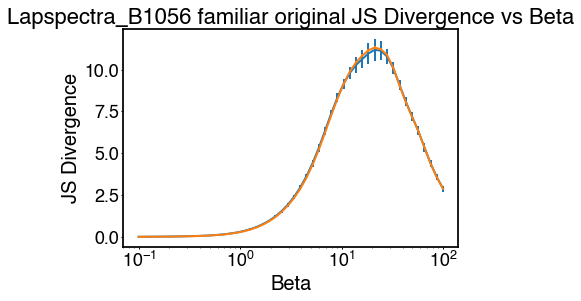

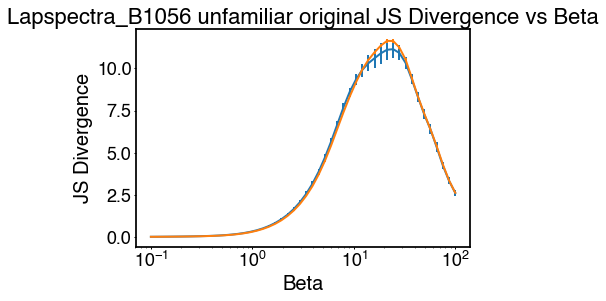

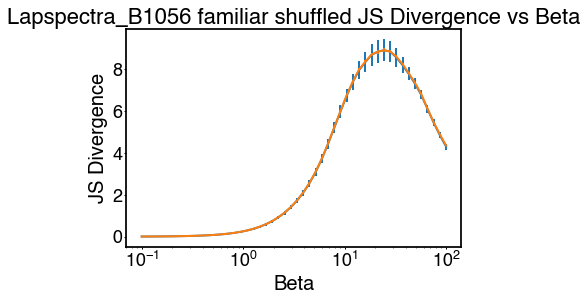

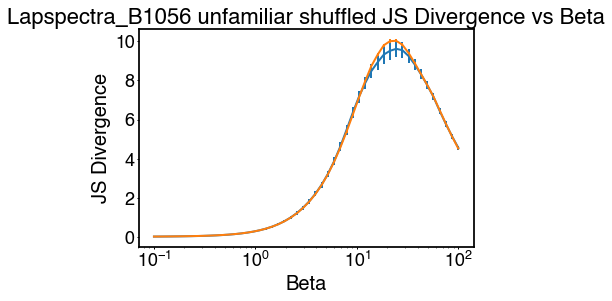

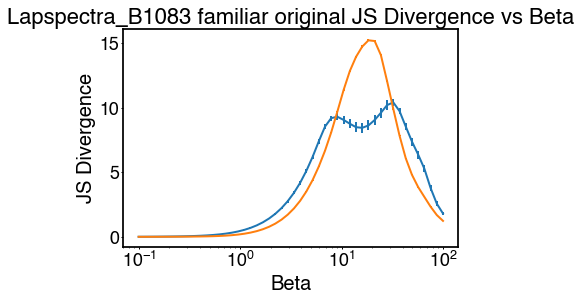

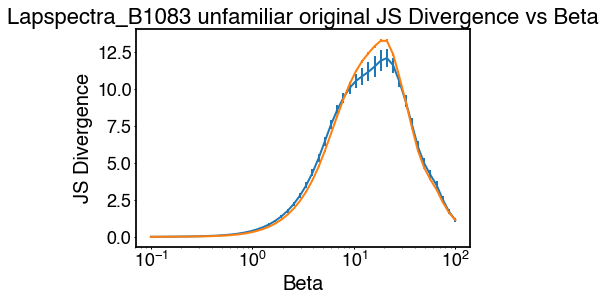

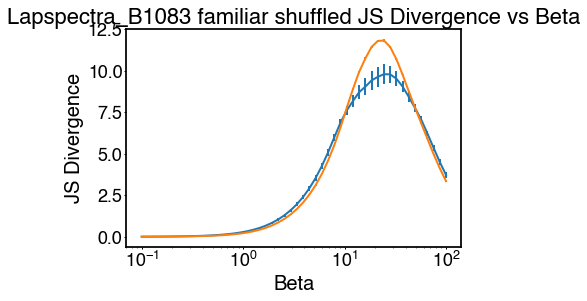

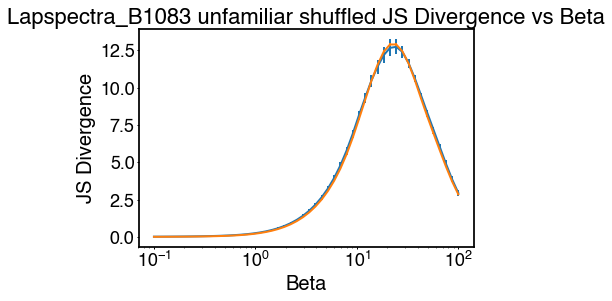

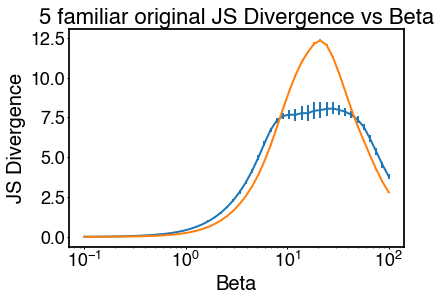

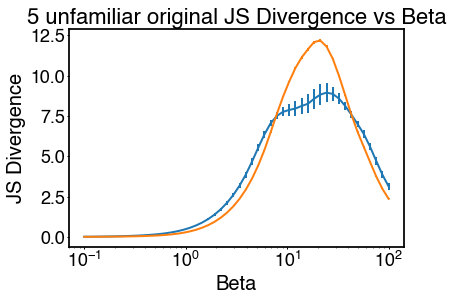

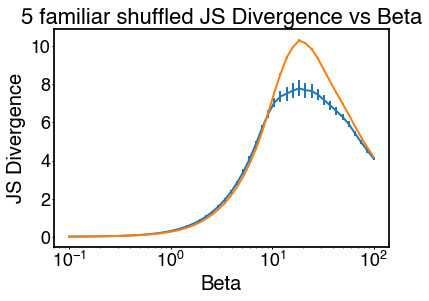

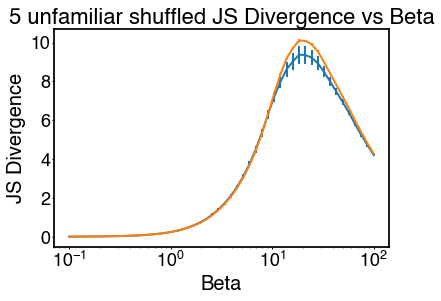

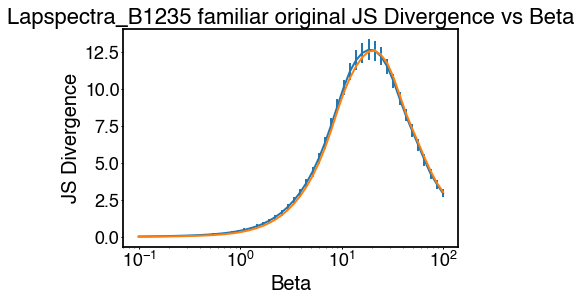

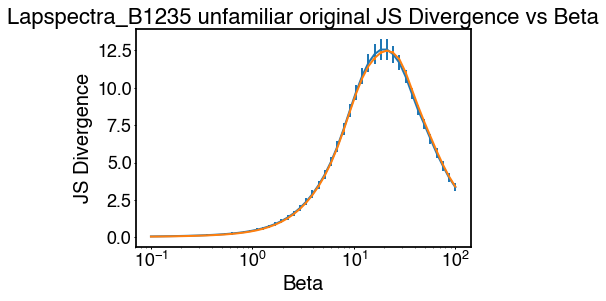

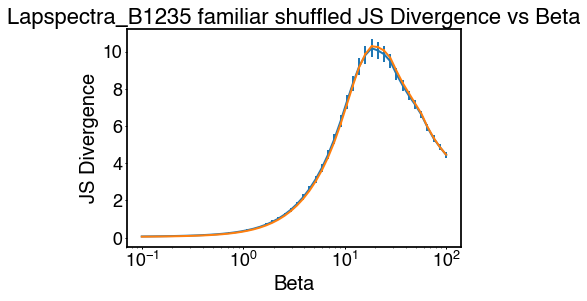

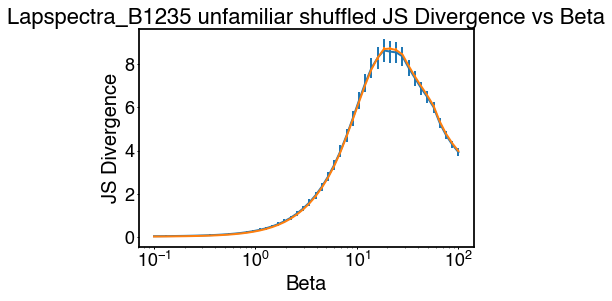

In [30]:
for indf, pair in enumerate(tqdm(file_pairs)):
    lap_file, m_file = pair
    
    params = get_lapfile_params(lap_file)
    with open(lap_file, 'rb') as f:
        lapspectra = pickle.load(f)
    with open(m_file, 'rb') as f:
        Mspectra = pickle.load(f)
    btwn_means = np.zeros(len(betas))
    btwn_stds = np.zeros(len(betas))
    wthn_means = np.zeros(len(betas))
    wthn_stds = np.zeros(len(betas))

    for ind, beta in enumerate(tqdm(betas)):
        mat = compute_JS_div_mtx(lapspectra, Mspectra, beta)
        (btwn, wthn) = compute_within_vs_between(mat, ntrials, nstim, diag=1)
        btwn_means[ind] = np.mean(btwn)
        btwn_stds[ind] = np.std(btwn) / np.sqrt(len(btwn))
        wthn_means[ind] = np.mean(wthn)
        wthn_stds[ind] = np.std(wthn) / np.sqrt(len(wthn))
    plt.figure()
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    plt.errorbar(betas, btwn_means, yerr=btwn_stds)
    plt.errorbar(betas, wthn_means, yerr=wthn_stds)
    plt.title('{} {} {} JS Divergence vs Beta'.format(params['bird'], params['fam'], params['shuf']))
    plt.xlabel('Beta')
    plt.ylabel('JS Divergence')
    plt.savefig(os.path.join(figsavepth, '{}-{}-{}-JSDivVsBeta-nodiag.pdf'.format(params['bird'], params['fam'], params['shuf'])))

Text(0,0.5,'JS Divergence')

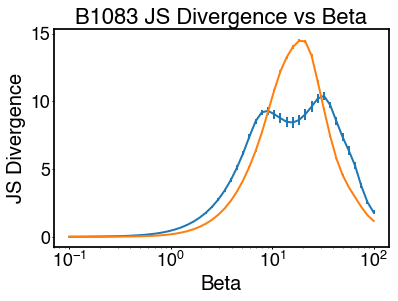

In [6]:
ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
plt.errorbar(betas, btwn_means, yerr=btwn_stds)
plt.errorbar(betas, wthn_means, yerr=wthn_stds)
plt.title('B1083 JS Divergence vs Beta')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')

In [11]:
wthn.shape

(1640,)

In [15]:
mat.shape
mtx = mat

In [23]:
stim_per_group = int(nstim//2)

btwn_data = mtx[0:stim_per_group*ntrials, stim_per_group*ntrials:]
within1 = mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials][np.triu_indices(stim_per_group*ntrials,1)]
within2 = mtx[stim_per_group*ntrials:, stim_per_group*ntrials:][np.triu_indices(stim_per_group*ntrials,1)]

within = np.concatenate((within1, within2))


In [24]:
within.shape

(1560,)

In [20]:
mtx[0:stim_per_group*ntrials, 0:stim_per_group*ntrials].shape

(40, 40)

In [22]:
np.triu_indices(40, 1)[0].shape

(780,)